In [3]:
library(MASS)
library (tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [47]:
results <- read.csv('results.csv')
races <- read.csv('races.csv')
drivers <- read.csv('drivers.csv')
circuits <- read.csv('circuits.csv')
lap_times <- read.csv('lap_times.csv')

In [48]:
lap_time_analysis <- lap_times %>%
  inner_join(races, by = "raceId") %>%
  inner_join(drivers, by = "driverId") %>%
  filter(year >= 2013 & year <= 2023) %>%
  select(year, circuitId, surname, lap, milliseconds, name, position)

In [49]:
lap_time_summary <- lap_time_analysis %>%
  mutate(lap_time_sec = milliseconds / 1000) %>%
  group_by(year, surname, circuitId) %>%
  summarize(avg_lap_time = mean(lap_time_sec, na.rm = TRUE)) %>%
  ungroup()

`summarise()` has grouped output by 'year', 'surname'. You can override using
the `.groups` argument.


In [50]:
lap_time_trends <- lap_time_summary %>%
  group_by(year) %>%
  summarize(overall_avg_lap_time = mean(avg_lap_time, na.rm = TRUE))

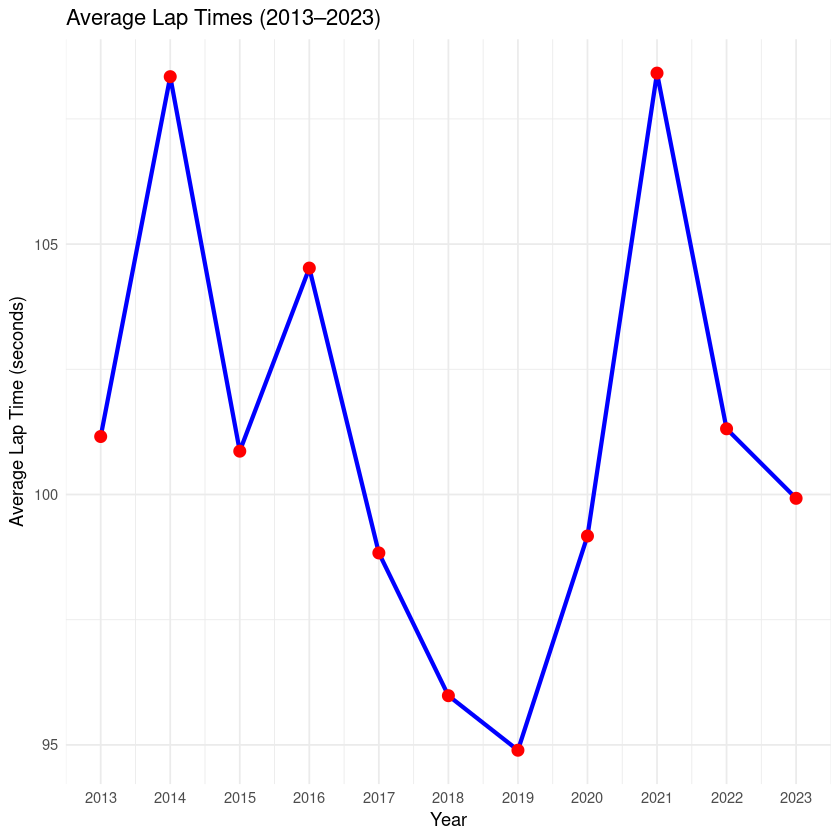

In [51]:
##average lap times (for all courses) in seconds for 2013-2023
ggplot(lap_time_trends, aes(x = year, y = overall_avg_lap_time)) +
  geom_line(color = "blue", linewidth = 1.2) +
  geom_point(color = "red", size = 3) +
  labs(
    title = "Average Lap Times (2013–2023)",
    x = "Year",
    y = "Average Lap Time (seconds)"
  ) +
  scale_x_continuous(breaks = seq(2013, 2023, by = 1)) +
  theme_minimal()

In [52]:
# Calculate average lap time and position by circuit and driver
track_performance <- lap_time_analysis %>%
  mutate(lap_time_sec = milliseconds / 1000) %>%
  group_by(circuitId, name, surname) %>%
  summarize(
    avg_lap_time = mean(lap_time_sec, na.rm = TRUE),
    avg_position = mean(position, na.rm = TRUE),  # Changed 'position' to 'positionOrder'
    races = n()
  ) %>%
  ungroup()

`summarise()` has grouped output by 'circuitId', 'name'. You can override using
the `.groups` argument.


In [53]:
track_summary <- track_performance %>%
  group_by(name) %>%
  summarize(
    overall_avg_lap_time = mean(avg_lap_time, na.rm = TRUE),
    overall_avg_position = mean(avg_position, na.rm = TRUE),
    races_analyzed = sum(races)
  ) %>%
  arrange(overall_avg_lap_time)

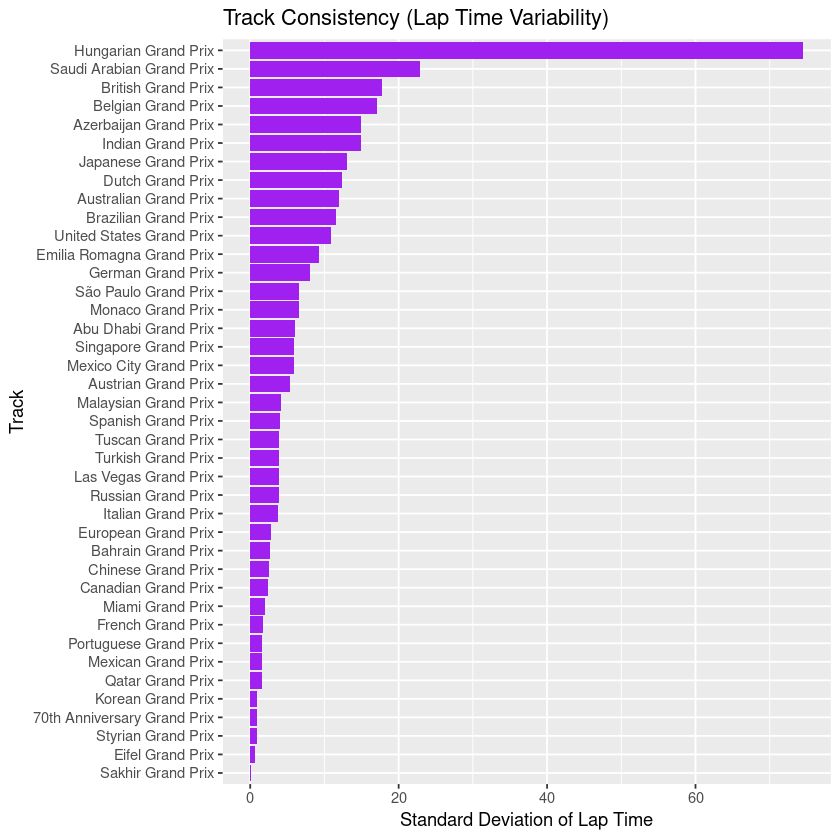

In [54]:
##Identifies tracks with high lap time variability i.e. low consistency
####Could be due to tracks with quicker lap times or more position variability
track_consistency <- track_performance %>%
  group_by(name) %>%
  summarize(
    lap_time_sd = sd(avg_lap_time, na.rm = TRUE),
    position_sd = sd(avg_position, na.rm = TRUE)
  ) %>%
  arrange(lap_time_sd)

ggplot(track_consistency, aes(x = reorder(name, lap_time_sd), y = lap_time_sd)) +
  geom_col(fill = "purple") +
  coord_flip() +
  labs(
    title = "Track Consistency (Lap Time Variability)",
    x = "Track",
    y = "Standard Deviation of Lap Time"
  )


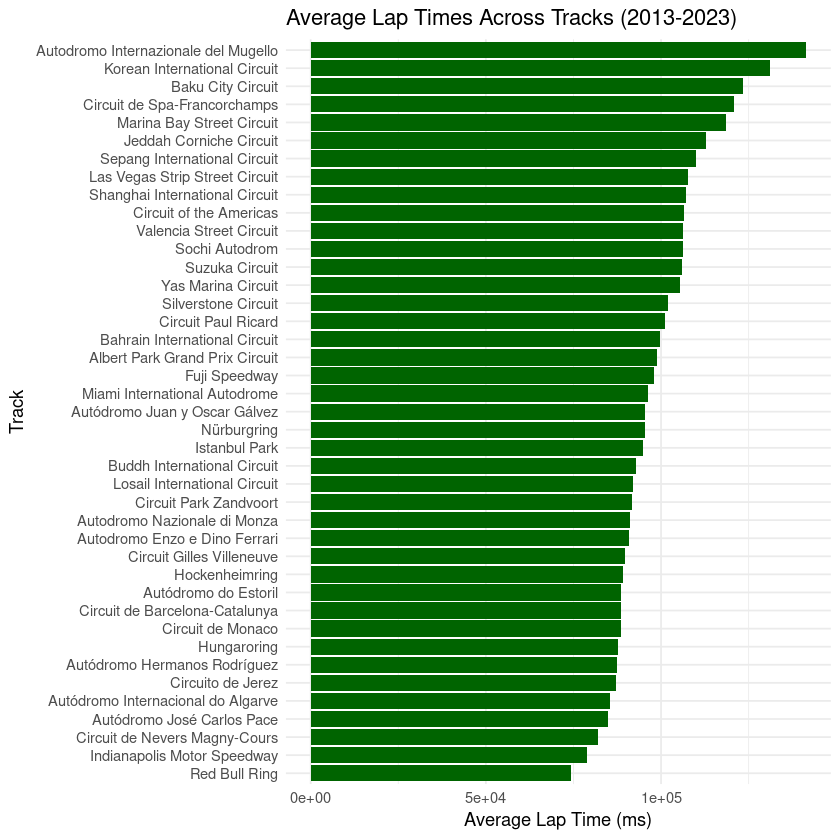

In [55]:
# Load necessary libraries
library(dplyr)
library(ggplot2)

results <- read.csv('results.csv')
races <- read.csv('races.csv')
drivers <- read.csv('drivers.csv')
circuits <- read.csv('circuits.csv')
lap_times <- read.csv('lap_times.csv')

#merging 'results' with 'races' to associate each result with a circuit
results_with_circuits <- results %>%
  inner_join(races, by = "raceId")  #using raceId to join with races.csv

#summary of track-wise accident rates (statusId != 1 indicates a problem)
accidents_per_track <- results_with_circuits %>%
  filter(statusId != 1) %>%  
  group_by(circuitId) %>%
  summarise(accident_rate = n() / n_distinct(raceId), .groups = "drop") %>%
  inner_join(circuits, by = "circuitId")  

#summary of track-wise lap times
avg_lap_times <- lap_times %>%
  inner_join(races, by = "raceId") %>%
  group_by(circuitId) %>%
  summarise(avg_lap_time = mean(milliseconds, na.rm = TRUE), .groups = "drop") %>%
  inner_join(circuits, by = "circuitId") 

#merging accident rates and lap times
track_analysis <- accidents_per_track %>%
  inner_join(avg_lap_times, by = c("circuitId", "circuitRef", "name", "location", "country"))

#visualizing lap times by track
ggplot(avg_lap_times, aes(x = reorder(name, avg_lap_time), y = avg_lap_time)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Average Lap Times Across Tracks (2013-2023)",
    x = "Track",
    y = "Average Lap Time (ms)"
  ) +
  theme_minimal()

# A tibble: 34 × 10
   circuitId accident_count circuitRef name  location country   lat    lng   alt
       <int>          <int> <chr>      <chr> <chr>    <chr>   <dbl>  <dbl> <int>
 1        70            157 red_bull_… Red … Spielbe… Austria  47.2  14.8    678
 2         4            143 catalunya  Circ… Montmeló Spain    41.6   2.26   109
 3        11            139 hungarori… Hung… Budapest Hungary  47.6  19.2    264
 4         3            111 bahrain    Bahr… Sakhir   Bahrain  26.0  50.5      7
 5         7            107 villeneuve Circ… Montreal Canada   45.5 -73.5     13
 6        24            105 yas_marina Yas … Abu Dha… UAE      24.5  54.6      3
 7         6            100 monaco     Circ… Monte-C… Monaco   43.7   7.42     7
 8        18            100 interlagos Autó… São Pau… Brazil  -23.7 -46.7    785
 9        69             99 americas   Circ… Austin   USA      30.1 -97.6    161
10        14             98 monza      Auto… Monza    Italy    45.6   9.28   162
# ℹ 24 m

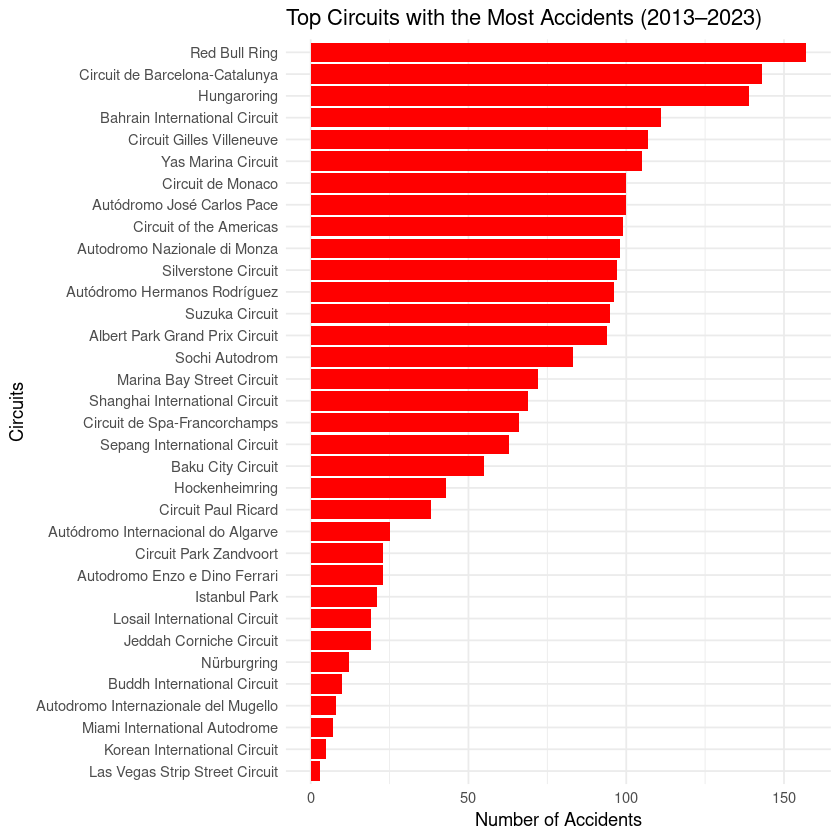

In [85]:
library(dplyr)
library(ggplot2)

#loading datasets
results <- read.csv('results.csv')
races <- read.csv('races.csv')
drivers <- read.csv('drivers.csv')
circuits <- read.csv('circuits.csv')
lap_times <- read.csv('lap_times.csv')
status <- read.csv('status.csv')

#filtering `races` for the years 2013 to 2023
filtered_races <- races %>%
  filter(year >= 2013 & year <= 2023)

#merging `results` with `races` and filter for accidents in the specified years
accident_data <- results %>%
  inner_join(filtered_races, by = "raceId") %>%  
  filter(statusId != 1) %>%  
  group_by(circuitId) %>%
  summarise(accident_count = n(), .groups = "drop") %>%  #counts accidents by circuit
  inner_join(circuits, by = "circuitId")  

#sort by the most accidents and display top circuits
top_accident_circuits <- accident_data %>%
  arrange(desc(accident_count))

#top circuits with the most accidents
print(top_accident_circuits)

# Visualize the top circuits with the most accidents (2013–2023)
library(ggplot2)
ggplot(top_accident_circuits, aes(x = reorder(name, accident_count), y = accident_count)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +
  labs(
    title = "Top Circuits with the Most Accidents (2013–2023)",
    x = "Circuits",
    y = "Number of Accidents"
  ) +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


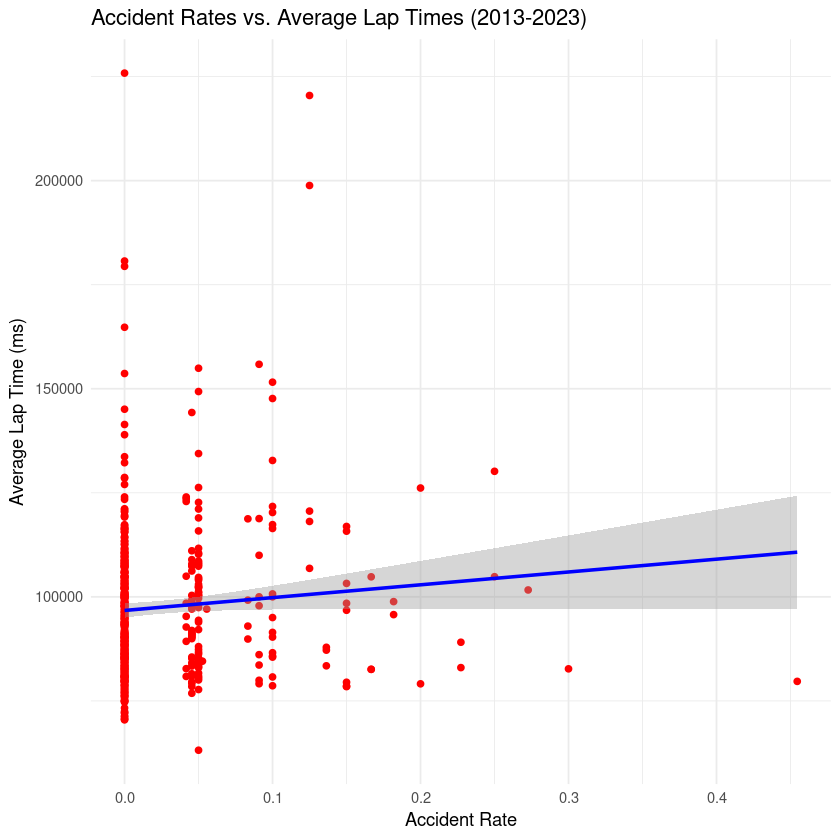

In [57]:
results_status <- merge(results, status, by.x = "statusId", by.y = "statusId")
races_results <- merge(races, results_status, by.x = "raceId", by.y = "raceId")
lap_times_races <- merge(lap_times, races, by.x = "raceId", by.y = "raceId")

#accident rates 
accident_rate <- races_results %>%
  group_by(raceId) %>%
  summarise(
    accident_rate = sum(str_detect(status, "Accident|Crash|DNF")) / n(),
    year = first(year)
  )

#calculate average lap times
average_lap_time <- lap_times_races %>%
  group_by(raceId) %>%
  summarise(
    avg_lap_time = mean(milliseconds, na.rm = TRUE),
    year = first(year)
  )

#merging accident rates and average lap times
race_summary <- merge(accident_rate, average_lap_time, by = c("raceId", "year"))

#scatter plot
ggplot(race_summary, aes(x = accident_rate, y = avg_lap_time)) +
  geom_point(color = "red") +
  geom_smooth(method = "lm", color = "blue") +
  labs(
    title = "Accident Rates vs. Average Lap Times (2013-2023)",
    x = "Accident Rate",
    y = "Average Lap Time (ms)"
  ) +
  theme_minimal()